<a href="https://colab.research.google.com/github/peoplecallitinsanity/CVC-hm/blob/main/HM5_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/CV5/utils')



In [3]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

from PIL.ExifTags import TAGS
from engine import train_one_epoch, evaluate
import utils
from torchvision import transforms as T  
import pandas as pd

In [4]:
data = pd.read_csv('/content/drive/MyDrive/cvc/car1.txt')
data.head()



image_path       x_min       y_min       x_max        y_max
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764800  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020261  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [5]:
data = pd.read_csv('/content/drive/MyDrive/cvc/car1.txt', sep=',')

In [6]:
data.columns

Index(['image_path ', ' x_min ', ' y_min ', ' x_max ', ' y_max'], dtype='object')

In [7]:
data['image_path '].values

array(['vid_4_1000.jpg', 'vid_4_10000.jpg', 'vid_4_10040.jpg',
       'vid_4_10020.jpg', 'vid_4_10060.jpg', 'vid_4_10100.jpg',
       'vid_4_10120.jpg', 'vid_4_10140.jpg', 'vid_4_1020.jpg',
       'vid_4_1040.jpg', 'vid_4_10480.jpg', 'vid_4_10500.jpg',
       'vid_4_10520.jpg', 'vid_4_1060.jpg', 'vid_4_10960.jpg',
       'vid_4_10980.jpg', 'vid_4_11000.jpg', 'vid_4_11020.jpg',
       'vid_4_11240.jpg', 'vid_4_11260.jpg', 'vid_4_11280.jpg',
       'vid_4_11380.jpg', 'vid_4_11400.jpg', 'vid_4_11420.jpg',
       'vid_4_11440.jpg', 'vid_4_11900.jpg', 'vid_4_11880.jpg',
       'vid_4_11920.jpg', 'vid_4_11940.jpg', 'vid_4_11960.jpg',
       'vid_4_11980.jpg', 'vid_4_12000.jpg', 'vid_4_12040.jpg',
       'vid_4_12100.jpg', 'vid_4_12060.jpg', 'vid_4_12080.jpg',
       'vid_4_12120.jpg', 'vid_4_12140.jpg', 'vid_4_12140.jpg',
       'vid_4_12160.jpg', 'vid_4_12160.jpg', 'vid_4_12160.jpg',
       'vid_4_12180.jpg', 'vid_4_12180.jpg', 'vid_4_12180.jpg',
       'vid_4_12200.jpg', 'vid_4_12200.jpg',

In [8]:
class DataSet(torch.utils.data.Dataset):
    
    def __init__(self,root, data_file, transform):
        self.root = root ### mapa cu fotografii
        self.transform = transform
        self.data = pd.read_csv(data_file, sep=',')
        self.imgs = self.data['image_path '].values
        self.path_to_data_file = data_file
        
    def __getitem__(self,idx):
        
        img_path = os.path.join(self.root,self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        
        for orientation in TAGS.keys() : 
            if TAGS[orientation]=='Orientation' : break 
        # Getting the exif
        exif=dict(img.getexif().items())
        # Rotating the image if the orientation is wrong.
        if len(exif)!=0:                                                             
            if orientation in exif.keys():
                if exif[orientation] == 3 : 
                    img=img.rotate(180, expand=True)
                elif exif[orientation] == 6 : 
                    img=img.rotate(270, expand=True)
                elif exif[orientation] == 8 : 
                    img=img.rotate(90, expand=True)
                    
        box_list = self.data[self.data['image_path ']==self.imgs[idx]][[' x_min ',' y_min ',' x_max ',' y_max']].values
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_obj = len(box_list)
        labels = torch.ones((num_obj,), dtype = torch.int64)
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        area = (boxes[:,3] - boxes[:, 1]) * (boxes[:,2] - boxes[:, 0])
        
        image_id = torch.tensor([idx])
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['image_id'] = image_id
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        return len(self.data)

In [9]:
transformations = T.Compose([T.ToTensor()])

dataset = DataSet('/content/drive/MyDrive/cvc/data2', 
                  '/content/drive/MyDrive/cvc/car1.txt', 
                  transformations)

torch.manual_seed(1)

indices = torch.randperm(len(dataset)).tolist()
train = torch.utils.data.Subset(dataset, indices[:100])
test = torch.utils.data.Subset(dataset, indices[100:])

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle=True, collate_fn = utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle=False, collate_fn = utils.collate_fn)

In [10]:
def get_model(num_clase):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    for param in model.parameters():
        param.required_grad = False
        
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_clase)
    
    return model



In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(DEVICE)
num_clase = 2
model = get_model(num_clase).to(DEVICE)

params  = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [12]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
num_epoch = 5

for epoch in range(num_epoch):
    
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, print_freq = 10)
    
    evaluate(model, test_loader, device=DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/100]  eta: 0:03:42  lr: 0.000055  loss: 0.6381 (0.6381)  loss_classifier: 0.5476 (0.5476)  loss_box_reg: 0.0855 (0.0855)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 2.2281  data: 1.0453  max mem: 1357
Epoch: [0]  [ 10/100]  eta: 0:01:42  lr: 0.000560  loss: 0.5842 (0.5979)  loss_classifier: 0.3651 (0.4018)  loss_box_reg: 0.1312 (0.1799)  loss_objectness: 0.0048 (0.0100)  loss_rpn_box_reg: 0.0042 (0.0062)  time: 1.1434  data: 0.3317  max mem: 1618
Epoch: [0]  [ 20/100]  eta: 0:01:27  lr: 0.001065  loss: 0.4582 (0.5499)  loss_classifier: 0.2464 (0.3150)  loss_box_reg: 0.1703 (0.2203)  loss_objectness: 0.0048 (0.0080)  loss_rpn_box_reg: 0.0057 (0.0067)  time: 1.0418  data: 0.2643  max mem: 1618
Epoch: [0]  [ 30/100]  eta: 0:01:14  lr: 0.001569  loss: 0.3566 (0.4694)  loss_classifier: 0.1237 (0.2449)  loss_box_reg: 0.2199 (0.2123)  loss_objectness: 0.0017 (0.0062)  loss_rpn_box_reg: 0.0051 (0.0059)  time: 1.0262  data: 0.2430  max mem: 1618


In [14]:
torch.save(model.state_dict(),'/content/drive/MyDrive/cvc/model.pth')

In [15]:
loaded_model = get_model(num_clase=2)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/cvc/model.pth'))



<All keys matched successfully>

Prediction with score above 0.3


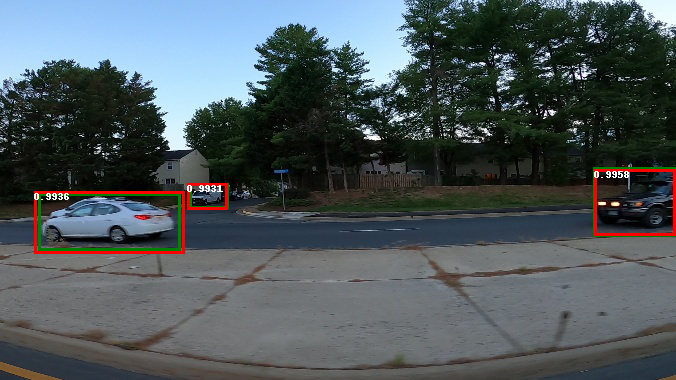

Prediction with score above 0.3


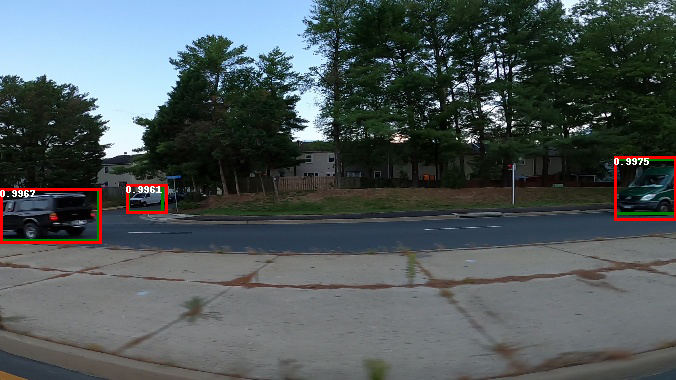

Prediction with score above 0.3


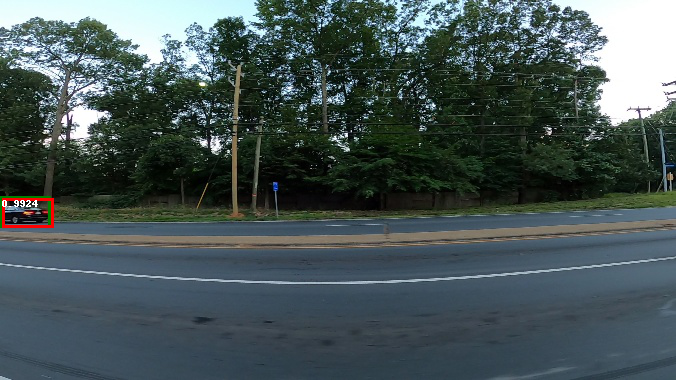

Prediction with score above 0.3


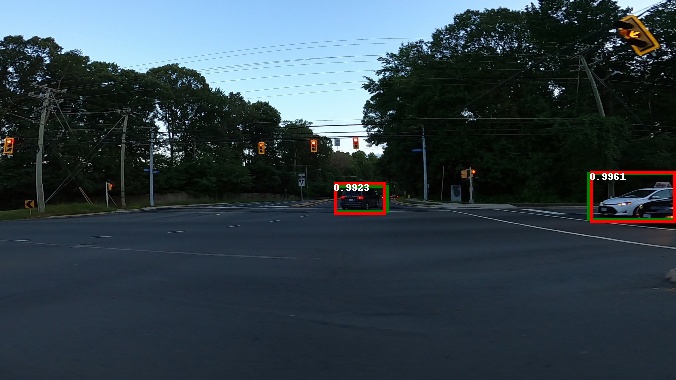

Prediction with score above 0.3


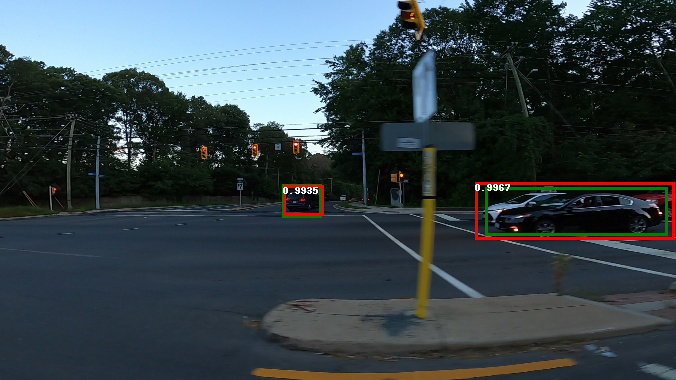

Prediction with score above 0.3


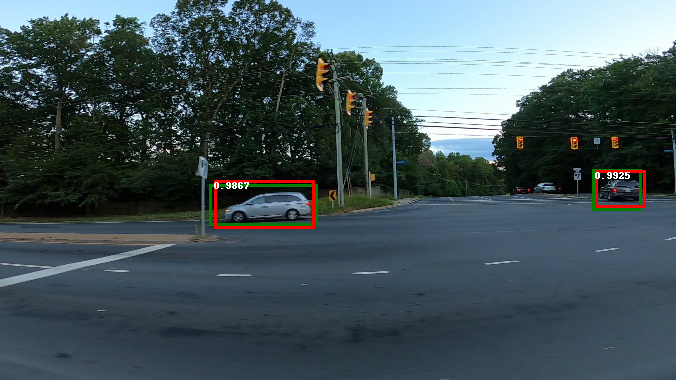

Prediction with score above 0.3


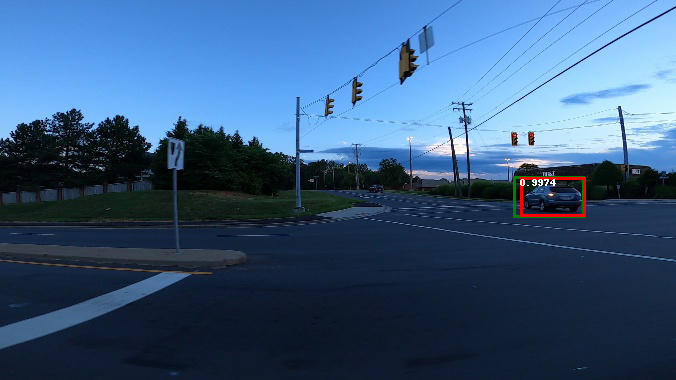

Prediction with score above 0.3


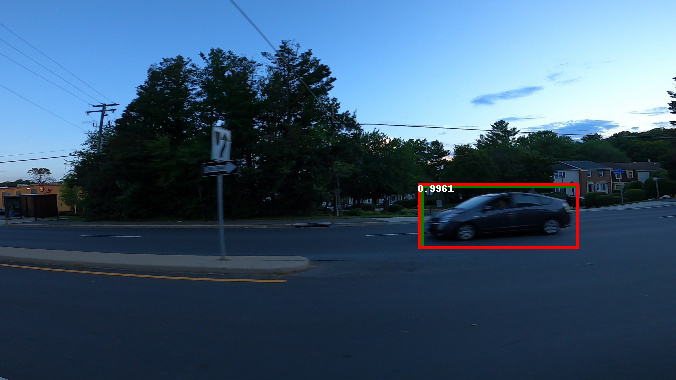

Prediction with score above 0.3


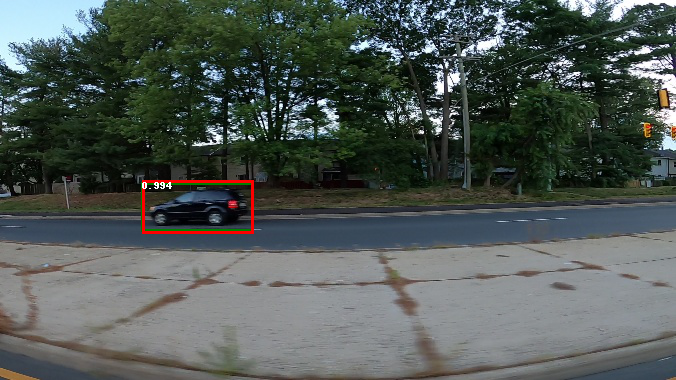

Prediction with score above 0.3


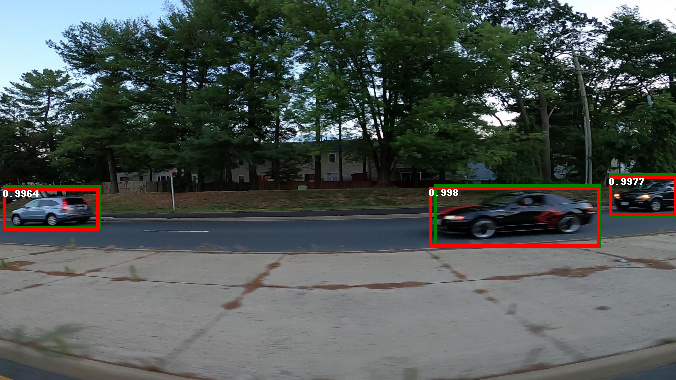

Prediction with score above 0.3


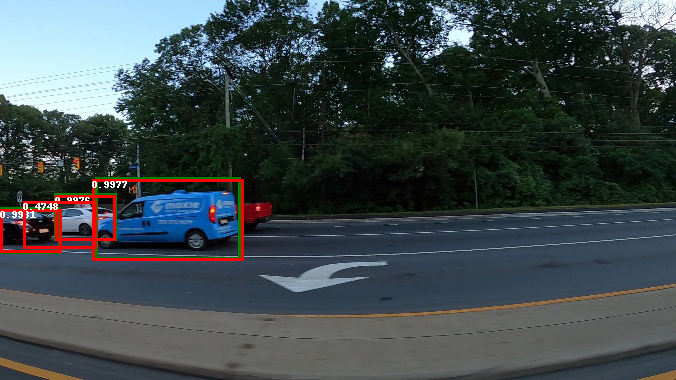

Prediction with score above 0.3


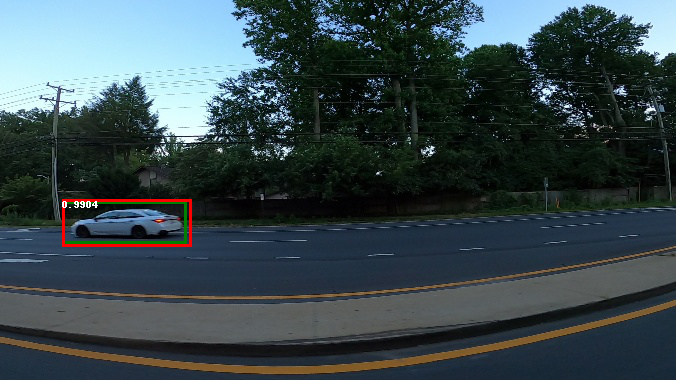

Prediction with score above 0.3


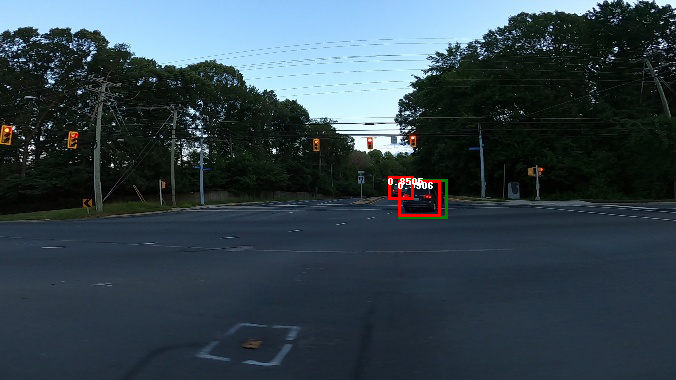

Prediction with score above 0.3


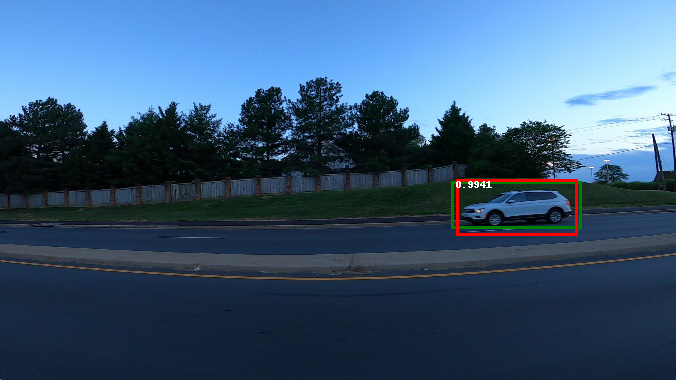

Prediction with score above 0.3


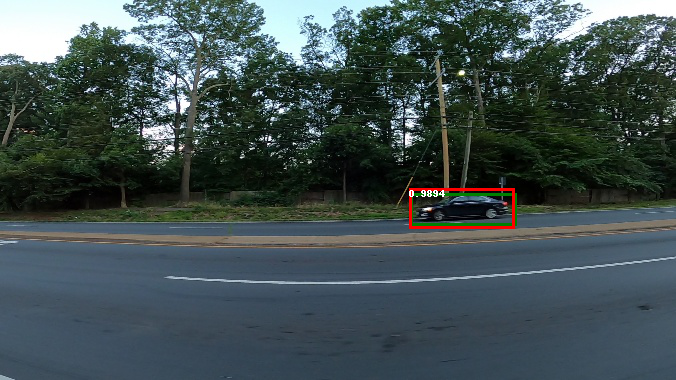

Prediction with score above 0.3


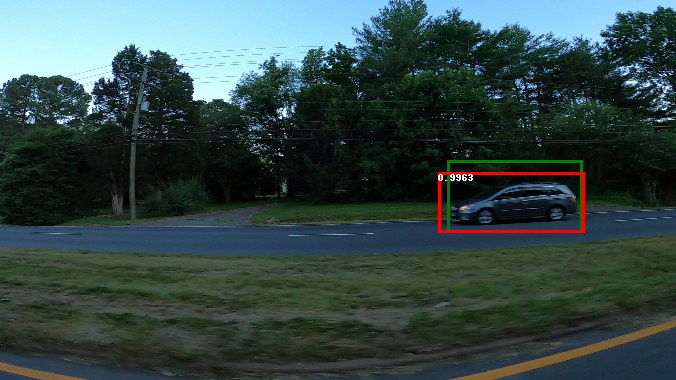

Prediction with score above 0.3


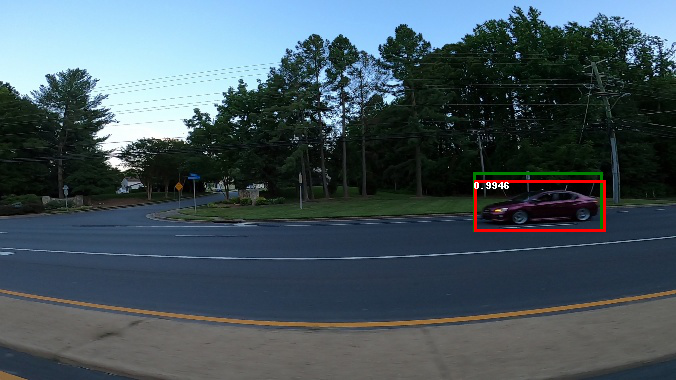

Prediction with score above 0.3


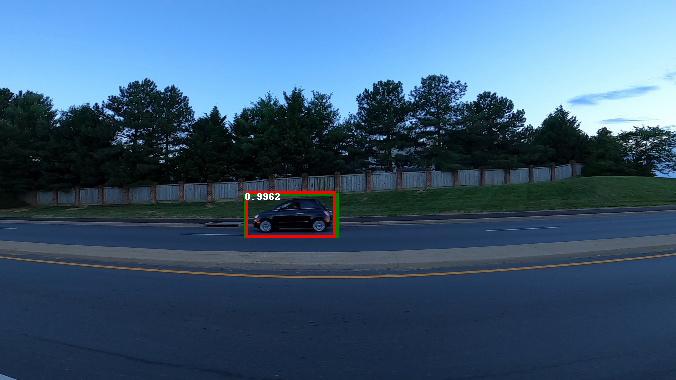

In [16]:
from PIL import ImageDraw
# Getting the image.
for idx in range(2,20):
    img, _ = test[idx]
    # Getting the object coordinates.
    label_boxes = np.array(test[idx][1]['boxes'])

    # Setting the model to eval state.
    loaded_model.eval()
    # Making the prediction.
    with torch.no_grad():
        prediction = loaded_model([img])

    # Getting an drawing the image.
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)

    # Drawing the real box around the object.
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
                       (label_boxes[elem][2], label_boxes[elem][3])],
                      outline='green', width=3)
    # Drawing the predicted box around the object.
    print("Prediction with score above 0.3")
    for element in range(len(prediction[0]['boxes'])):
        boxes = prediction[0]['boxes'][element].cpu().numpy()                                     
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=4)

        if score > 0.3:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
                         outline='red', width=3)
            draw.text((boxes[0], boxes[1]), text=str(score))
    display(image)